In [1]:
#####################################################
###       Train an Auto Damage Clain Model        ###
#####################################################

###################
### Credentials ###
###################

import os
import sys
from pathlib import Path

filepath = input("file path to credentials: ")
sys.path.append(filepath)
from credentials import hostname, session, port, protocol, wd, output_dir, git_dir, token_dir, token, token_refresh, token_pem

In [2]:
#############################
### Connect with SAS Viya ###
#############################

import swat

access_token = open(token, "r").read()
conn =  swat.CAS(hostname=hostname, username=None, password=access_token, ssl_ca_list=token_pem, protocol=protocol)
print(conn.serverstatus())

NOTE: Grid node action status report: 1 nodes, 9 total actions executed.
[About]

 {'CAS': 'Cloud Analytic Services',
  'CASCacheLocation': 'CAS Disk Cache',
  'CASHostAccountRequired': 'OPTIONAL',
  'Copyright': 'Copyright © 2014-2025 SAS Institute Inc. All Rights Reserved.',
  'GlobalReadOnlyMode': 'NO',
  'ServerTime': '2025-08-13T14:20:54Z',
  'System': {'Hostname': 'controller.sas-cas-server-default.innovationlab.svc.cluster.local',
   'Linux Distribution': 'Red Hat Enterprise Linux release 8.10 (Ootpa)',
   'Model Number': 'x86_64',
   'OS Family': 'LIN X64',
   'OS Name': 'Linux',
   'OS Release': '5.15.0-1090-azure',
   'OS Version': '#99-Ubuntu SMP Thu May 22 21:15:50 UTC 2025'},
  'Transferred': 'NO',
  'Version': '4.00',
  'VersionLong': 'V.04.00M0P06092025',
  'Viya Release': '20250702.1751427964045',
  'Viya Version': 'Stable 2025.06',
  'license': {'expires': '08Jul2027:00:00:00',
   'gracePeriod': 0,
   'site': 'CIS CREATE INNOVATION LAB (ENTERPRISE-RISK-MRM-SPI',
   'si

In [3]:
### import actions for modeling
conn.loadactionset('image')
conn.loadactionset("sampling")
conn.loadactionset("deepLearn")

NOTE: Added action set 'image'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00318s, user: 0.00315s, mem: 0.221mb

In [ ]:
### set names of caslibs and tables
caslib_images = 'images'
caslib_output = 'public'
caslib_models = 'public'
table_output = 'auto_claim_images'
table_sample = 'auto_claim_images_sample'
table_resized = 'auto_claim_images_resized'
table_resized_sample = 'auto_claim_images_resized_sample'

In [ ]:
### assign caslib to directory where images reside (set subDirectories=True if multiple directories)
### caslib is required to load images into CAS table
### images could be in Github (on SAS Server in Viya) or a path to a file system
imagepath = input("file path within viya to Github directory with images: ")

conn.table.addCaslib(
        name=caslib_images,
		description='',
        session=True,
		path=imagepath,
        subDirectories=True,
        datasource=dict(srctype="path")
        )

NOTE: 'images' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'images'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
0,images,PATH,,/innovationlab-export/innovationlab/homes/Chri...,,1.0,1.0,1.0,0.0,0.0,0.0,Not Specified


In [ ]:
### load images into CAS table
### images are labeled based on directory names
auto_claim_images = conn.image.loadimages(
    caslib=caslib_images,
    recurse=True,
    labelLevels=-1,
    addColumns=("CHANNELCOUNT", "CHANNELTYPE", "DEPTH", "HEIGHT", "ORIENTATION", "POSITION", "SPACING", "SPAN", "WIDTH"),
    casOut=dict(caslib=caslib_output, name=table_output, replace=True)
     )

NOTE: Loaded 107 images from /innovationlab-export/innovationlab/homes/Chris.Parrish@sas.com/chris_git/data/images/auto_damage/ into table auto_claim_images.


In [ ]:
### view first rows of table with images
conn.table.fetch(
    table=dict(caslib=caslib_output, name=table_output),
    to=10
    )

NOTE: Varbinary column '_orientation_' may not be in a format that can be displayed consistently.
NOTE: Varbinary column '_position_' may not be in a format that can be displayed consistently.
NOTE: Varbinary column '_spacing_' may not be in a format that can be displayed consistently.
NOTE: Varbinary column '_image_' may not be in a format that can be displayed consistently.


,_channelCount_,_channelType_,_depth_,_height_,_orientation_,_position_,_spacing_,_span_,_width_,_image_,_size_,_path_,_label_,_type_,_id_
0,3,8U,1,1024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,1536,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,3562448,/innovationlab-export/innovationlab/homes/Chri...,ai_damage,png,1
1,3,8U,1,3024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,4032,b'\xff\xd8\xff\xe0\x00\x14JFIF\x00\x01\x01\x01...,3874563,/innovationlab-export/innovationlab/homes/Chri...,no_damage,jpg,50
2,3,8U,1,3024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,4032,b'\xff\xd8\xff\xe0\x00\x14JFIF\x00\x01\x01\x01...,4285512,/innovationlab-export/innovationlab/homes/Chri...,real_damage,jpg,89
3,3,8U,1,1024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,1536,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2933962,/innovationlab-export/innovationlab/homes/Chri...,ai_damage,png,2
4,3,8U,1,3024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,4032,b'\xff\xd8\xff\xe0\x00\x14JFIF\x00\x01\x01\x01...,6980296,/innovationlab-export/innovationlab/homes/Chri...,no_damage,jpg,49
5,3,8U,1,3024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,4032,b'\xff\xd8\xff\xe0\x00\x14JFIF\x00\x01\x01\x01...,6408260,/innovationlab-export/innovationlab/homes/Chri...,real_damage,jpg,96
6,3,8U,1,1024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,1536,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2907138,/innovationlab-export/innovationlab/homes/Chri...,ai_damage,png,3
7,3,8U,1,3024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,4032,b'\xff\xd8\xff\xe0\x00\x14JFIF\x00\x01\x01\x01...,6494988,/innovationlab-export/innovationlab/homes/Chri...,no_damage,jpg,48
8,3,8U,1,3024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,4032,b'\xff\xd8\xff\xe0\x00\x14JFIF\x00\x01\x01\x01...,7281758,/innovationlab-export/innovationlab/homes/Chri...,real_damage,jpg,97
9,3,8U,1,3024,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...,1,4032,b'\xff\xd8\xff\xe0\x00\x14JFIF\x00\x01\x01\x01...,4491058,/innovationlab-export/innovationlab/homes/Chri...,no_damage,jpg,4


In [ ]:
### the CAS table may be large, so sampling to view some of the images
conn.srs(
    table=dict(caslib=caslib_output, name=table_output),
    output=dict(casOut=dict(name=table_sample, replace=True), copyVars="ALL"),
    samppct=10, seed=123
    )

srs_out=conn.CASTable(table_sample)
print(srs_out.fetch(to=20))

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=123 for sampling.
NOTE: Varbinary column '_orientation_' may not be in a format that can be displayed consistently.
NOTE: Varbinary column '_position_' may not be in a format that can be displayed consistently.
NOTE: Varbinary column '_spacing_' may not be in a format that can be displayed consistently.
NOTE: Varbinary column '_image_' may not be in a format that can be displayed consistently.
[Fetch]

 Selected Rows from Table AUTO_CLAIM_IMAGES_SAMPLE
 
    _channelCount_ _channelType_  _depth_  _height_                                      _orientation_                                         _position_                                          _spacing_  _span_  _width_                                            _image_   _size_                                             _path_ _type_  _id_
 0               3            8U        1      3024  b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x0...  b'\x00\x00\x00\x00\x00\x00\x00\

In [ ]:
### create dataframe from sample of images ###

auto_claim_images_df =  conn.CASTable(name=table_sample).to_frame()
auto_claim_images_df.dtypes

SWATError: Unknown session.: e48f896a-db73-ef46-9b0e-b3e79df652ec

In [7]:
### view images in the notebook ###

from PIL import Image
from IPython.display import Image, display
from io import BytesIO

num_images_to_view = len(auto_claim_images_df) # or limit # to integer 
for i in range(num_images_to_view):
    image_bytes = auto_claim_images_df['_image_'].iloc[i]
    display(Image(data=image_bytes))
    # load the images to display in desktop viewer
    #image = Image.open(BytesIO(image_bytes))
    #image.show()

NameError: name 'auto_claim_images_df' is not defined

In [ ]:
### adjust images ###

conn.image.processimages(
    table=dict(caslib=caslib_output, name=table_output),
    casout=dict(caslib=caslib_output, name=table_resized, replace=True),
    steps=[dict(step=dict(stepType='RESIZE', type='BASIC', width=416, height=416))]
    )

NOTE: The table AUTO_CLAIM_IMAGES contains encoded images.
NOTE: 54 of 54 images were processed successfully and saved as encoded images to the table auto_claim_images_resized.


,casLib,Name,Rows,Columns,casTable
0,Public,auto_claim_images_resized,54,5,"CASTable('auto_claim_images_resized', caslib='..."


In [ ]:
conn.srs(
    table=dict(caslib=caslib_output, name=table_resized),
    output=dict(casOut=dict(name=table_resized_sample, replace=True), copyVars="ALL"),
    samppct=10, seed=123
    )

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=123 for sampling.


[OutputCasTables]

    casLib                              Name Label  Rows  Columns                                           casTable
 0  images  auto_claim_images_resized_sample           5        5  CASTable('auto_claim_images_resized_sample', c...

[SRSFreq]

 Frequencies
 
    NObs  NSamp
 0    54      5

+ Elapsed: 0.291s, user: 0.276s, sys: 0.0204s, mem: 125mb

In [ ]:
auto_claim_images_resized_df =  conn.CASTable(name=table_resized_sample).to_frame()

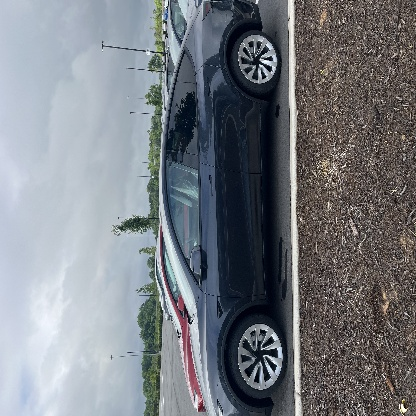

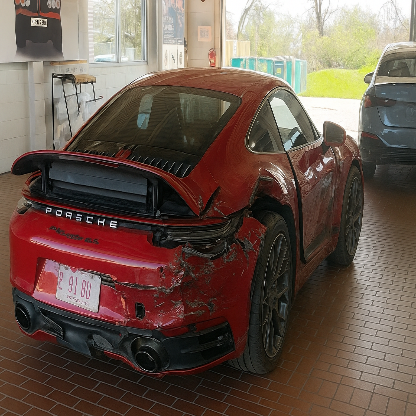

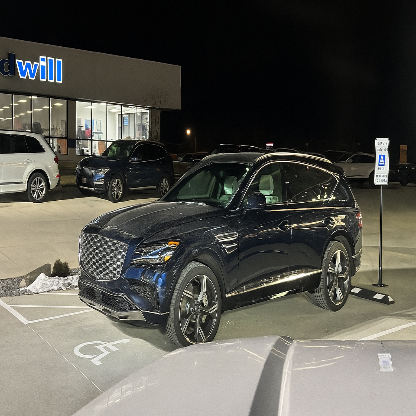

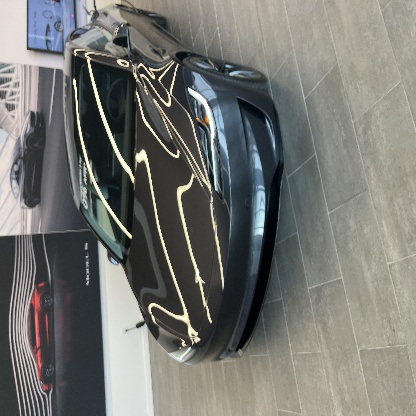

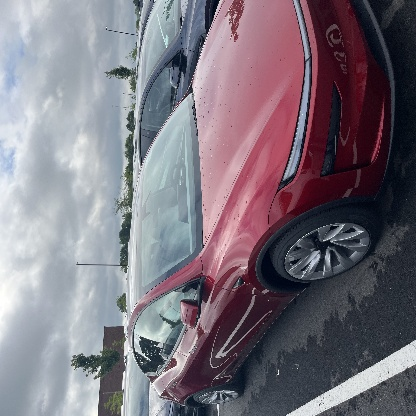

In [92]:
num_images_to_view = len(auto_claim_images_resized_df) # or limit # to integer 
for i in range(num_images_to_view):
    image_bytes = auto_claim_images_resized_df['_image_'].iloc[i]
    display(Image(data=image_bytes))

In [ ]:
/FSBU/pre_trained_models/resnet50_caffe

In [ ]:
### partition image set
conn.srs(table=,
         samppct=80,
         samppct=20,
         partInd=True,
         output=dict(casout=dict(caslib= name=, replace=True, copyVars='ALL')))

In [ ]:
### shuffle images
conn.table.shuffle(
    table=dict(name=),
    casout=dict(name=, replace=1)
)

In [ ]:
training_caslib = 'public'
training_table = 
initial_weights =
model_weights = 

In [ ]:
conn.table.loadTable(
    caslib='pretrained',
    path='.../resnet50_caffee.sashdat'
    casout=
    )
    path='.../resent50_weights.sashdat'
    path='.../resent50_weights_attr.sashdat'

In [ ]:
conn.deepLearn.dlTrain(
    table=dict(caslib=training_caslib, name=training_table),
    #casout=dict(caslib='public', name='auto_claim_images_resized', replace=True),
    model=dict(name='resnet50'),
    initWeights=dict(name=initial_weights),
    modelWeights=dict(name=model_weights),
    inputs='_image_',
    target='_label_',
    optimizer=dict(minibatchsize=1, algorithm=dict(method='VANILLA', learningrate=5E-3), maxepochs=5, logleve=3)
    )
				table={caslib="&imageTrainingCaslibName", 
                         name="&imageTrainingTableName"} 
                model={name="ResNet50"}  
                initWeights={name='ResNet50_weights'} 
                modelWeights={name='ResNet50_weights_giraffe', replace=1} 
                inputs='_image_'  
                target='_label_' nominal={'_label_'} 
                optimizer={minibatchsize=1,  
                           algorithm={method='VANILLA', learningrate=5E-3} 
                           maxepochs=5, 
                           loglevel=3}

In [ ]:
localizer - YOLO
classification
image authenticator
instance segmentation
Patch-Based Vision Transformer for Identifying Synthetic Media (PV-ISM)